# Implement VeloVAE in mouse hippocampus development

To compare with [Gu et al.](https://www.biorxiv.org/content/10.1101/2022.07.08.499381v1) in bioRxiv (doi: https://doi.org/10.1101/2022.07.08.499381; version 1), in this notebook, we follow the instructions of [VeloVAE](https://github.com/welch-lab/VeloVAE) and implement VeloVAE in mouse hippocampus development data. The selected cells with genes in mouse hippocampus development data are the same as the datasets used in our study. The input data could be downloaded from [DentateGyrus.h5ad](https:DentateGyrus.h5ad).

## Build environment and install dependencies

We create the environment of VeloVAE by running the commands below in an anaconda environment. We download and install the latest VeloVAE from https://github.com/welch-lab/VeloVAE on the main thread (commit: 018ee60998c9b63f441fdfc4836dbd5baadf1459). The code could also be downloaded [here](https://github.com/welch-lab/VeloVAE). We install cellDancer to plot figures.

`conda create -n velovae python=3.7.6`

`conda activate velovae`

`pip install scvelo`

`pip install loess`

`pip install 'your_path/Source Code/cellDancer'`

`pip install -r 'your_path/Source Code/cellDancer/requirements.txt'`

# Import packages

In [1]:
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import os.path
sys.path.append('../')
import velovae as vv
import celldancer as cd

# Load mouse hippocampal dentate gyrus neurogenesis data


In [2]:
dataset = "Neuro"
adata = anndata.read("your_path/DentateGyrus.h5ad")

In [3]:
# Set the parent folder names for saving model parameters, data and figures.
model_path_base = f"checkpoints/{dataset}"
figure_path_base = f"figures/{dataset}"
data_path_base = f"data/{dataset}"
os.makedirs(figure_path_base, exist_ok=True)

# Run VeloVAE

We run VeloVAE with the same configurations in the instruction. 

In [4]:
figure_path = figure_path_base+"/VAE"
model_path = model_path_base+"/VAE"
data_path = data_path_base

In [5]:
torch.set_num_threads(16)
torch.manual_seed(2022)
np.random.seed(2022)

vae = vv.VAE(adata, tmax=20, dim_z=5, device='cpu')

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Initialization using the steady-state and dynamical models.
Gaussian Prior.


In [6]:
vae.train(adata, gene_plot=gene_plot, plot=True, figure_path=figure_path, embed="TSNE")

--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 100, test iteration: 198
Epoch 1: Train ELBO = -1198.297, Test ELBO = -113057.516, 	 Total Time =   0 h :  0 m : 20 s
Epoch 100: Train ELBO = 3059.183, Test ELBO = 3032.646, 	 Total Time =   0 h : 14 m : 30 s
*********       Stage 1: Early Stop Triggered at epoch 145.       *********
*********                      Stage  2                       *********
Cell-wise KNN Estimation.
Percentage of Invalid Sets: 0.007
Average Set Size: 988
Finished. Actual Ti

In [7]:
vae.save_model(model_path, 'encoder_vae', 'decoder_vae')
vae.save_anndata(adata, 'vae', data_path, file_name="neuro_out.h5ad")

# Visualize the phase portraits of sample genes


In [8]:
import matplotlib.pylab as plt
import math

key = "vae"
basis = "TSNE"

In [9]:
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity', n_jobs=12)
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity', basis=basis)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 12/16 cores)


  0%|          | 0/18140 [00:00<?, ?cells/s]

    finished (0:01:56) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:05) --> added
    'vae_velocity_TSNE', embedded velocity vectors (adata.obsm)


In [10]:
adata.write_h5ad(data_path_base+"/neuro_out.h5ad")
adata

AnnData object with n_obs × n_vars = 18140 × 2159
    obs: 'Age', 'Cell_Conc', 'ChipID', 'ClusterName', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE1', 'TSNE2', 'Target_Num_Cells', 'Tissue', 'Transcriptome', 'cDNA_Lib_Ok', 'ngperul_cDNA', 'clusters', 'celltype', 'vanilla_time', 'vanilla_std_t', 'vae_time', 'vae_std_t', 'vae_t0', 'fullvb_time', 'fullvb_std_t', 'fullvb_t0', 'partition', 'brode_time', 'brode_label', 'vae_velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'vanilla_alpha', 'vanilla_beta', 'vanilla_gamma', 'vanilla_toff', 'vanilla_ton', 'vanilla_scaling', 'vanilla_sigma_u', 'vanilla_sigma_s', 'vae_alpha', 'vae_beta', 'vae_gamma', 'vae_ton', 'vae_scaling', 'vae_sigma_u', 'vae_sigma_s', 'vae_likelihood', 'fullvb_log

In [11]:
# transfer anndata to pandas dataframe
# Note that VeloVADE does not have the feature to calculate du/dt, we set it to 0.
from adata_to_df import adata_to_df
df = adata_to_df(adata, \
    us_para=['Mu', 'Ms'], us_pred_para=[f'{key}_velocity_u', f'{key}_velocity'], \
    cell_type_para='clusters', embed_para=f'X_{basis}', \
    embed_pred_para=f'{key}_velocity_{basis}')
df

,gene_name,unsplice,splice,unsplice_predict,splice_predict,cellID,clusters,embedding1,embedding2,velocity1,velocity2
0,Rgs20,0.069478,0.021971,0.069478,0.035350,10X83_2:AAACGGGGTCTCTTTAx,ImmGranule2,18.931086,-1.862429,0.058905,-0.022261
1,Rgs20,0.085834,0.016256,0.085834,0.031023,10X83_2:AACCATGGTTCAACCAx,ImmGranule2,18.419891,-1.282895,0.057640,-0.034744
2,Rgs20,0.068644,0.047774,0.068644,0.059185,10X83_2:AACACGTTCTGAAAGAx,CA2-3-4,2.369887,16.868419,0.009161,0.040780
3,Rgs20,0.045387,0.018101,0.045387,-0.019843,10X83_2:AAAGATGCATTGAGCTx,CA,-5.351040,10.676485,-0.019619,0.049789
4,Rgs20,0.040457,0.012846,0.040457,0.011477,10X83_2:AACCATGTCTACTTACx,CA1-Sub,-6.189126,11.754900,-0.003690,0.014775
...,...,...,...,...,...,...,...,...,...,...,...
39164255,Gpm6b,0.876650,1.276089,0.876650,1.273298,10X84_3:TTTCCTCCACCATCCTx,ImmGranule1,10.812611,-2.487668,0.058755,-0.020609
39164256,Gpm6b,2.024897,5.152006,2.024897,4.824040,10X84_3:TTTGTCACATGAAGTAx,CA2-3-4,8.246204,23.482788,0.000888,0.001298
39164257,Gpm6b,1.848051,1.491445,1.848051,3.664976,10X84_3:TTTCCTCCACGGTAAGx,nIPC,-3.441272,-4.917364,0.040915,0.023852
39164258,Gpm6b,0.696361,1.189091,0.696361,1.184842,10X84_3:TTTGTCAAGCGTCAAGx,ImmGranule2,16.394199,-6.143549,0.036416,0.000965


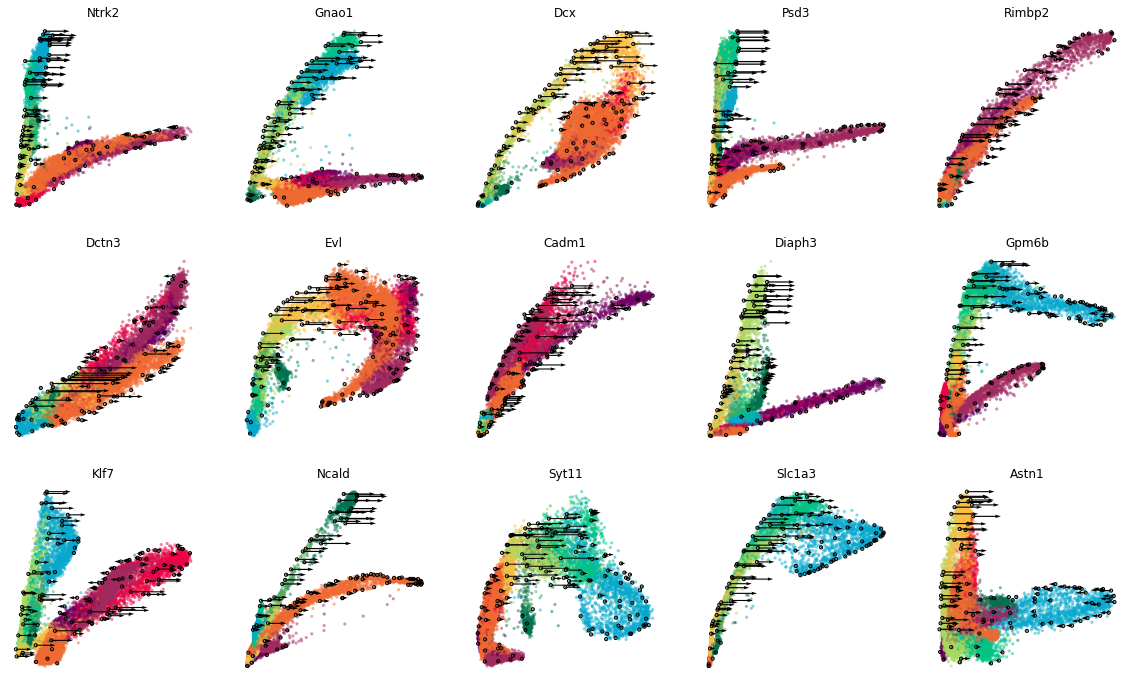

In [12]:
gene_list=['Ntrk2','Gnao1','Dcx','Psd3','Rimbp2','Dctn3','Evl','Cadm1','Diaph3','Gpm6b','Klf7','Ncald','Syt11','Slc1a3','Astn1']

ncols=5
height=math.ceil(len(gene_list)/5)*4
fig = plt.figure(figsize=(20, height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cd.cdplt.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=df,
        custom_xlim=None,
        custom_ylim=None,
        colors=cd.cdplt.colormap.colormap_neuro,
        alpha=0.5,
        s = 10,
        velocity=True,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    ax.axis('off')
plt.savefig(figure_path_base+f'{key}_gene_phase.pdf')
plt.show()